In [ ]:
'''
import cv2

def rotate_video(input_path, output_path, angle=90):
    # Open the input video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        #print("Error opening video file.")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) if angle in [90, 270] else int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) if angle in [90, 270] else int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change codec if needed
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Rotate frame
        if angle == 90:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            frame = cv2.rotate(frame, cv2.ROTATE_180)
        elif angle == 270:
            frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)

        out.write(frame)

    cap.release()
    out.release()
    #print(f"Rotated video saved as {output_path}")

    '''

Average wrist distance: 198.37 pixels
Average wrist distance: 194.48 pixels
Average wrist distance: 190.25 pixels
Average wrist distance: 193.79 pixels
Average wrist distance: 195.35 pixels
Average wrist distance: 197.61 pixels
Average wrist distance: 194.62 pixels
Average wrist distance: 193.94 pixels
Average wrist distance: 194.70 pixels
Average wrist distance: 197.57 pixels
Average wrist distance: 200.26 pixels
Average wrist distance: 200.64 pixels
Average wrist distance: 198.94 pixels
Average wrist distance: 197.87 pixels
Average wrist distance: 197.18 pixels
Average wrist distance: 195.88 pixels
Average wrist distance: 194.96 pixels
Average wrist distance: 194.47 pixels
Average wrist distance: 194.64 pixels
Average wrist distance: 195.32 pixels
Average wrist distance: 196.57 pixels
Average wrist distance: 197.47 pixels
Average wrist distance: 197.41 pixels
Average wrist distance: 197.76 pixels
Average wrist distance: 197.40 pixels
Average wrist distance: 197.34 pixels
Average wris

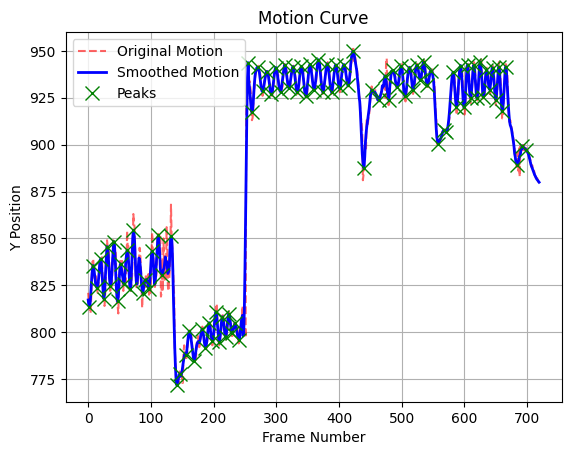

Pixel to cm ratio: 0.26 cm/pixel
Average depth of detected peaks: 4.72 pixels
Rate of detected peaks: 2.19 Hz


In [28]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import deque
import time
import math
from scipy.signal import savgol_filter, find_peaks
import matplotlib.pyplot as plt

# Constants
MIN_KEYPOINT_CONFIDENCE = 0.2  # Minimum confidence for keypoints
RESCUER_PROXIMITY_THRESH = 0.3  # Relative distance threshold for rescuer detection
HUSSEIN_SHOULDER_TO_SHOULDER = 45

# Keypoint indices (YOLO pose model)
LEFT_SHOULDER = 5
RIGHT_SHOULDER = 6
LEFT_WRIST = 9
RIGHT_WRIST = 10
LEFT_ELBOW = 7
RIGHT_ELBOW = 8

# Global variables
chest_point = None  # (x, y) in image-space coordinates
firstTimeRotated = True
peaks_max = []  # Indices of peaks in the motion curve
peaks_min = []  # Indices of valleys in the motion curve
shoulder_to_shoulder_dist = []  # Distance between shoulders in pixels
midpoints_list = []
y_smoothed = []
peaks = []
right_arm_angles = []  # Store right arm angles
left_arm_angles = []  # Store left arm angles
wrist_distances = []

model = YOLO("yolo11n-pose.pt")

def detect_chest_landscape(frame):
    results = model(frame, verbose=False)
    if not results or len(results[0].keypoints.xy) == 0:
        return None

    keypoints = results[0].keypoints
    boxes = results[0].boxes
    confs = keypoints.conf  # shape: [num_persons, 17]

    for i, (kp, box) in enumerate(zip(keypoints.xyn, boxes.xywh)):
        x, y, w, h = box
        if h < w * 1.2:  # Not vertical enough
            continue

        if confs[i][LEFT_SHOULDER] < MIN_KEYPOINT_CONFIDENCE or confs[i][RIGHT_SHOULDER] < MIN_KEYPOINT_CONFIDENCE:
            continue

        left_shoulder = kp[LEFT_SHOULDER][:2].cpu().numpy()  # Convert tensor to numpy array
        right_shoulder = kp[RIGHT_SHOULDER][:2].cpu().numpy()  # Convert tensor to numpy array

        return (left_shoulder, right_shoulder)

    return None

def initialize_chest_detection(cap):
    global chest_point
    shoulder_samples = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    for i in range(15):
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, verbose=False)
        if not results or len(results[0].keypoints.xy) == 0:
            continue

        debug_frame = results[0].plot()
        shoulders = detect_chest_landscape(frame)

        if shoulders:
            left_shoulder, right_shoulder = shoulders
            shoulder_samples.append((left_shoulder, right_shoulder))

            lx, ly = (left_shoulder * np.array([frame.shape[1], frame.shape[0]])).astype(int)
            rx, ry = (right_shoulder * np.array([frame.shape[1], frame.shape[0]])).astype(int)

            cv2.circle(debug_frame, (lx, ly), 5, (0, 0, 255), -1)
            cv2.circle(debug_frame, (rx, ry), 5, (0, 0, 255), -1)
            cv2.putText(debug_frame, f"CHEST pts - Frame {i+1}", (lx, ly - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                        

        cv2.imshow("Chest Detection Debug", debug_frame)
        if cv2.waitKey(400) == ord('q'):
            break

    if shoulder_samples:
        avg_left = np.median([s[0] for s in shoulder_samples], axis=0)
        avg_right = np.median([s[1] for s in shoulder_samples], axis=0)

        avg_left_px = avg_left * np.array([frame.shape[1], frame.shape[0]])
        avg_right_px = avg_right * np.array([frame.shape[1], frame.shape[0]])

        midpoint = (avg_left_px + avg_right_px) / 2
        shoulder_dist = np.linalg.norm(avg_left_px - avg_right_px)

        # Move downward by 20% of shoulder distance (tunable)
        downward_offset = 0.4 * shoulder_dist
        chest_point = (int(midpoint[0]), int(midpoint[1] + downward_offset))
        #print(f"Chest point initialized at: {chest_point}")
        cv2.circle(frame, chest_point, 8, (0, 55, 120), -1)
        cv2.putText(frame, "AYWA", (chest_point[0] + 5, chest_point[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

    cv2.destroyWindow("Chest Detection Debug")


def find_rescuer(pose_results, frame_shape):
    if not pose_results or len(pose_results[0].boxes) == 0:
        return None

    boxes = pose_results[0].boxes.xywh.cpu().numpy()
    horizontal_objects = []

    for box in boxes:
        x, y, w, h = box
        if w > h * 1.5:
            horizontal_objects.append((x, y, w, h))

    if not horizontal_objects:
        return None

    people = []
    for i, box in enumerate(boxes):
        x, y, w, h = box
        if h > w * 1.2 and len(pose_results[0].keypoints) > i:
            people.append((i, x, y))

    if not people:
        return None

    min_distance = float('inf')
    rescuer_idx = None

    for (i, px, py) in people:
        for (hx, hy, hw, hh) in horizontal_objects:
            distance = np.sqrt(((px - hx) / frame_shape[1]) ** 2 + ((py - hy) / frame_shape[0]) ** 2)
            if distance < min_distance and distance < RESCUER_PROXIMITY_THRESH:
                min_distance = distance
                rescuer_idx = i

    return rescuer_idx


def smoothMidpoints():
    """
    Applies Savitzky-Golay filter to smooth the y-coordinates of midpoints.
    """
    global midpoints_list
    global y_smoothed

    if len(midpoints_list) > 5:  # Ensure enough data points for smoothing
        midpoints_list = np.array(midpoints_list)
        y_smoothed = savgol_filter(midpoints_list[:, 1], window_length=10, polyorder=2, mode='nearest')
    else:
        y_smoothed = midpoints_list[:, 1]  # Use original data if not enough points


# Detect the peaks of the motion curve
def detectPeaks():
    """
    Detects the peaks of the motion curve.
    """

    global y_smoothed
    global peaks
    global peaks_max
    global peaks_min

    if y_smoothed.size == 0:
        #print("No smoothed values found.")
        return  # Do nothing if there are no smoothed values
            
    peaks_max, _ = find_peaks(y_smoothed, distance=10)
    peaks_min, _ = find_peaks(-y_smoothed, distance=10)
    peaks = np.sort(np.concatenate((peaks_max, peaks_min)))

def plotMidpoints():
    """
    Plots the original and smoothed y-coordinates of the midpoints.
    """
          
    global midpoints_list
    global y_smoothed   
    global peaks


    if midpoints_list.size == 0:
        return  # Do nothing if there are no midpoints
    
    y = midpoints_list[:, 1]

    # Plot motion curve
    plt.plot(y, label="Original Motion", color="red", linestyle="dashed", alpha=0.6)
    plt.plot(y_smoothed, label="Smoothed Motion", color="blue", linewidth=2)

    
    if peaks.size > 0:
        plt.plot(peaks, y_smoothed[peaks], "x", color="green", markersize=10, label="Peaks")
    else:
        print("No peaks detected.")
    
    plt.xlabel("Frame Number")
    plt.ylabel("Y Position")
    plt.title("Motion Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

def calculatePixelToCM():
    global shoulder_to_shoulder_dist
    
    if len(shoulder_to_shoulder_dist) > 0:
        sum_dist = np.sum(shoulder_to_shoulder_dist)
        avg_dist = sum_dist / len(shoulder_to_shoulder_dist)
        cm_px_ratio = HUSSEIN_SHOULDER_TO_SHOULDER / avg_dist

        return cm_px_ratio
    else:
        #print("Shoulder distance is zero or not initialized.")
        return None

def calculateDepth(cm_px_ratio):
    """
    Calculate the average depth of detected peaks.
    
    Returns:
    float: The average depth in pixels.
    """
    global y_smoothed
    global peaks
    global peaks_max
    return np.mean(np.abs(np.diff(y_smoothed[peaks]))) * cm_px_ratio if len(peaks) > 1 else None


def calculateRate(fps):
    """
    Calculate the rate of detected peaks.
    
    Parameters:
    fps (int): Frames per second of the video.
    
    Returns:
    float: The calculated rate in Hz.
    """
    global peaks_max

    return 1 / (np.mean(np.diff(peaks_max)) / fps) if len(peaks_max) > 1 else None
        
def process_frame(frame, width, height):
    global chest_point
    global firstTimeRotated
    global midpoints_list
    global shoulder_to_shoulder_dist
    
    rotated = False

    if width > height:
        # Rotate the frame 90 degrees clockwise to portrait mode
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        rotated = True

    # Process the frame using YOLO model
    results = model(frame, verbose=False)

    if not results:
        return frame

    annotated_frame = results[0].plot()

    if rotated and firstTimeRotated:
        # Adjust chest point for rotated frame
        if chest_point is not None:
            chest_point = (height - chest_point[1], chest_point[0])
            firstTimeRotated = False

    # Draw the chest point
    cv2.circle(annotated_frame, chest_point, 8, (255, 0, 0), -1)
    cv2.putText(annotated_frame, "CHEST", (chest_point[0] + 5, chest_point[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # Find and draw rescuer
    rescuer_idx = find_rescuer(results, frame.shape[:2])

    if rescuer_idx is not None:
         #Find the rescurer midpoint of writss and append it to a list
        left_wrist = results[0].keypoints.xy[rescuer_idx][LEFT_WRIST][:2].cpu().numpy()
        right_wrist = results[0].keypoints.xy[rescuer_idx][RIGHT_WRIST][:2].cpu().numpy()

        left_shoulder = results[0].keypoints.xy[rescuer_idx][LEFT_SHOULDER][:2].cpu().numpy()
        right_shoulder = results[0].keypoints.xy[rescuer_idx][RIGHT_SHOULDER][:2].cpu().numpy()

        left_elbow = results[0].keypoints.xy[rescuer_idx][LEFT_ELBOW][:2].cpu().numpy()
        right_elbow = results[0].keypoints.xy[rescuer_idx][RIGHT_ELBOW][:2].cpu().numpy()

        #calculate shoulder distance
        shoulder_to_shoulder_dist_mag = np.linalg.norm(left_shoulder - right_shoulder)  # Calculate shoulder distance

        #print(f"Shoulder to shoulder distance: {shoulder_to_shoulder_dist_mag:.2f} pixels")
        

        shoulder_to_shoulder_dist.append(shoulder_to_shoulder_dist_mag) # Update shoulder distance

        wrist_midpoint = (left_wrist + right_wrist) / 2

        # Draw the midpoint
        wrist_midpoint_px = wrist_midpoint.astype(int)


        ##print(f"Rescuer wrist midpoint: {wrist_midpoint_px.type()}")
        

        # Append the midpoint to the list
        midpoints_list.append(wrist_midpoint_px)
        
        cv2.circle(annotated_frame, tuple(wrist_midpoint_px), 8, (0, 255, 0), -1)
        cv2.putText(annotated_frame, "MIDPOINT", (wrist_midpoint_px[0] + 5, wrist_midpoint_px[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


        boxes = results[0].boxes.xyxy.cpu().numpy()
        x1, y1, x2, y2 = boxes[rescuer_idx].astype(int)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(annotated_frame, "RESCUER", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
##############################POSTURE DETECTION#######################################

         # Check arms bent
        
        arm_status = check_arms_bent(annotated_frame, left_elbow, left_shoulder, left_wrist,
                                      right_elbow, right_shoulder, right_wrist)                              
        if arm_status:
            cv2.putText(annotated_frame, f"Warning: {arm_status}", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            
        # Check one handed
        if is_one_handed_cpr(left_wrist, right_wrist):
            cv2.putText(annotated_frame, "Warning: One-Handed CPR detected!", (50, 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)


    return annotated_frame

def findAngle(img, p1, p2, p3, draw=True):
        

        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3

        #print(f"Point 1: {p1}, Point 2: {p2}, Point 3: {p3}")

        #print(f"Coordinates: {x1}, {y1}, {x2}, {y2}, {x3}, {y3}")
        
        angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - 
                             math.atan2(y1 - y2, x1 - x2))
        if angle < 0:
            angle += 360
        

        if draw:
            #print("Before Line")
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 3)
            cv2.line(img, (int(x3), int(y3)), (int(x2), int(y2)), (255, 255, 255), 3)

            #print("After Line")
            cv2.circle(img, (int(x1), int(y1)), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (int(x1), int(y1)), 15, (0, 0, 255), 2)
            cv2.circle(img, (int(x2), int(y2)), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (int(x2), int(y2)), 15, (0, 0, 255), 2)
            cv2.circle(img, (int(x3), int(y3)), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (int(x3), int(y3)), 15, (0, 0, 255), 2)
            cv2.putText(img, str(int(angle)), (int(x2) - 50, int(y2) + 50),
                cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        return angle
    

def is_right_arm_bent(img, elbow, shoulder, wrist):
        """
        Checks if the arm is bent based on the elbow angle.
      
        """
        angle = findAngle(img, wrist, elbow, shoulder)
        right_arm_angles.append(angle)  # Store latest angle
        avg_angle = np.mean(right_arm_angles)  # Compute smoothed angle

        return avg_angle > 210  # Consider bent if above this threshold
    

def is_left_arm_bent(img, elbow, shoulder, wrist):
    """
    Checks if the arm is bent based on the elbow angle.

    """


    angle = findAngle(img, wrist, elbow, shoulder)
    left_arm_angles.append(angle)  # Store latest angle
    avg_angle = np.mean(left_arm_angles)  # Compute smoothed angle

    return avg_angle < 150  # Consider bent if below this threshold

def is_one_handed_cpr(left_wrist, right_wrist):
        """
        Checks if the person is using only one hand.
        """
        global wrist_distances

        # Calculate the distance between wrists
        wrist_distance = np.linalg.norm(left_wrist - right_wrist)
        
        # Store the wrist distance in the queue
        wrist_distances.append(wrist_distance)

        # Compute smoothed wrist distance
        avg_wrist_distance = np.mean(wrist_distances)

        print(f"Average wrist distance: {avg_wrist_distance:.2f} pixels")

        # Return True if the average wrist distance is above threshold
        return avg_wrist_distance > 170  #! will need to adjust this threshold based on the video PX TO CM CONVERSION



def check_arms_bent(img, elbowLeft, shoulderLeft, wristLeft, elbowRight, shoulderRight, wristRight):
    """
    Determines if one or both arms are bent using elbow angles.
    """

    left_bent = is_left_arm_bent (img, elbowLeft, shoulderLeft, wristLeft)  # Left arm: (elbow, shoulder, wrist)


    right_bent = is_right_arm_bent (img, elbowRight, shoulderRight, wristRight)  # Right arm: (elbow, shoulder, wrist)

    if left_bent and right_bent:
        return "Both arms are bent"
    elif left_bent:
        return "Left arm is bent"
    elif right_bent:
        return "Right arm is bent"
    else:
        return None
        



def main():
    cap = cv2.VideoCapture("video_4.mp4")
    if not cap.isOpened():
        #print("Error opening video file.")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    initialize_chest_detection(cap)

    cv2.namedWindow("Rescue Analysis", cv2.WINDOW_NORMAL)
    pTime = 0  # Previous time for FPS calculation
    frame_count = 0
    fps = 0  # Initialize FPS variable

    #initialize a timer
    start_time = time.time()
    elapsed_time = 0    
    while True:
        
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        
        output_frame = process_frame(frame, width, height)
        

        if(frame_count % 10 == 0):

            cTime = time.time()
            fps = 10 / (cTime - pTime) if pTime else 0
            pTime = cTime
        
        cv2.putText(output_frame, f"FPS: {int(fps)}", (70, 50), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
        cv2.imshow("Rescue Analysis", output_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    #end the timer
    elapsed_time = time.time() - start_time
    #print(f"Elapsed time: {elapsed_time:.2f} seconds")

    smoothMidpoints()
    detectPeaks()
    plotMidpoints()

    #print(f"Frame count: {frame_count}")
    cm_px_ratio = calculatePixelToCM()
    if cm_px_ratio:
        print(f"Pixel to cm ratio: {cm_px_ratio:.2f} cm/pixel")
    else:
        print("Failed to calculate pixel to cm ratio.")

    depth = calculateDepth(cm_px_ratio)
    if depth:
        print(f"Average depth of detected peaks: {depth:.2f} pixels")
    else:
        print("Failed to calculate average depth.")
    
    rate = calculateRate(30)
    if rate:
        print(f"Rate of detected peaks: {rate:.2f} Hz")
    else:
        print("Failed to calculate rate.")

    

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()
